# EDA 005 - DeepStrain - cMAC results reproduction

Now that we _know_ we can run DeepStrain, the next step is reproducing cMAC results with this methodology to see if we're using all the steps and, furthermore, take a leap forward and try it on other databases.

## Objectives 📋

This analysis has the following goals:
- Run DeepStrain on all cMAC patients.
- Reproduce results on an already said dataset.
- Write a script to reproduce this EDA's results.

## Imports ⚙️

In [1]:
# Internals of these functions were covered in EDA-004.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from reproduce_cmac import (
    get_images,
    get_segmentation,
    get_strain_and_motion,
    get_strain_values,
    get_motion_error,
)

# Constants
DATASET_FOLDER = "/Users/yhibo/Downloads/MHD_Data"
OUTPUT_FOLDER = os.getcwd()
patients = [f"v{p}" for p in range(1, 17) if p != 3]
es_times = [10, 11, 11, 11, 11, 9, 9, 10, 10, 9, 11, 9, 10, 11, 11]
ES = {k: v for (k, v) in zip(patients, es_times)}

ModuleNotFoundError: No module named 'seaborn'

## Data loading & preprocessing 📈

We need to load images from a certain patient of the cMAC/cMAC dataset. To do so:

- We load the `.mhd` images for images (and segmentations if we're not using CarSON).
- We join them into `.nii` 4d images.
- We calculate the segmentations.
- We calculate strain and motion.


### Converting images to Nifti

In [ ]:
# See EDA-004 or reproduce-cmac.py for the internals of this function.
get_images(DATASET_FOLDER, OUTPUT_FOLDER, use_our_segs=False)

### Segmentation

Only needed if we don't want to use the segmentation we already have from other methods.

Now that we have our images in the correct format to use them within the DeepStrain workflow, we must run the segmentations on images (grab the ground truth on all of them) and save them to disk, using CarSON.



In [ ]:
# See EDA-004 or reproduce-cmac.py for the internals of this function.
get_segmentation(OUTPUT_FOLDER)

### Motion estimation

Once we have the images correctly saved to niftis and segmentations were obtained (either through CarSON or another method, and always saved in the right format) we can run the motion estimation.



In [ ]:
# See EDA-004 or reproduce-cmac.py for the internals of this function.
get_strain_and_motion(OUTPUT_FOLDER)

## Validations ✔️

### Segmentation validation

To reproduce this results we would need to use ACDC which is outside of this EDA's scope.

This is just an skipped test.

Result: SKIPPED ⏩

### Motion validation

To reproduce this results, we must:
- Load the landmarks are be able to visualize them and their motion.
- Find which material point they belong in the original MRI
- Get the displacement of said point in the images and check their endpoint.
- Calculate the AEPE (absolute end point error) of the landmark and the image.

First, we will grab the center that we used to crop the image to (128, 128) pixels. Then, we calculate the index of origin of that subimage in the original image by doing:

$$\mathcal{O}'_{index} = \text{center}_{index} - \left< 64, 64, \text{slices}/2\right>, $$

Once we get the index representing the cropped image we transform it into physical coordinates by multiplying it by the image spacing and adding the image origin:

$$\mathcal{O}' = \text{round} ( \mathcal{O}'_{index} \cdot \text{spacing}) + \mathcal{O}$$

Now, with this new origin, and the landmark points $\mathcal{P}_{ED}$, we can obtain the indexes of the displacement field that belong to the landmarks:

$$\Phi_{index} = \text{round} (\mathcal{P}_{ED} - \mathcal{O}') \cdot \text{spacing}^{-1}$$

Having the transform index, we can obtain the transform and then transform the points, and then measure the error considering only in-plane information:

$$\mathcal{P}_{ES} = \text{Phi} \circ \mathcal{P}_{ED} \Rightarrow \text{AEPE} = || P_{ES} - P_{ED} ||_2.$$

Median AEPE error:  3.259057473652702  ±  2.2285944912004005


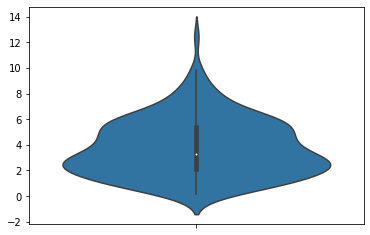

In [16]:
errors = get_motion_error(OUTPUT_FOLDER)
print("Median AEPE error: ", np.median(errors), " ± ", np.std(errors))
ax = sns.violinplot(y=errors)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2901da790>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x28ffee430>,
 'cmins': <matplotlib.collections.LineCollection at 0x2901dac40>,
 'cbars': <matplotlib.collections.LineCollection at 0x156cac070>}

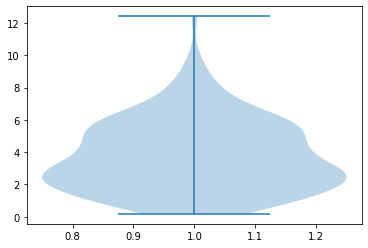

In [22]:
plt.violinplot(errors)

We can see that although we didn't get the same value they did in the paper, there are some differences listed in their repository that will be further discussed in the Strain validation section that may explain why there's a discrepance. We're at 3.22mm error, vs 2.98mm, with a deviation of 2.18mm vs 1.52mm.

Result: PASS  ✔️

### Strain validation

Note that the VCN network **is not provided** with DeepStrain code. Therefore, we will _mostly_ reproduce their results and compare with what they achieved in their uploaded notebook.



In [1]:
# This is practically the same as reproduce_cmac.get_strain_values.
results = pd.DataFrame()
theirs = dict(name="paper", Err=19.7, Ecc=-15.3, Srr_d=1.3, Srr_s=-1.4, Scc_d=-1.2, Scc_s=0.8)
results = results.append(theirs, ignore_index=True)
results = results.append({"name": "replica", **get_strain_values(OUTPUT_FOLDER)}, ignore_index=True)
results.set_index("name")

NameError: name 'pd' is not defined

Num GPUs Available:  1


We can see that although there are some differences with the paper results, we must understand that:

- We did not use their myocardial centering network (VCN) as it is proposed in the paper,
- We used an approximation for time resolution to get the strain rate.

Moreso, DeepStrain repository gives the same "warnings" on their reproducibility notebooks.  This are the same values they arrived at in the cMAC notebook.

I will write this one off as "pass", with a warning on two beforesaid points.

Result: PASS  ✔️

## Conclusions 📝

We were able to "pretty much" reproduce DeepStrain results up to the same precision they had on their repository.
